# Import Module

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import NLTKWordTokenizer
from nltk.tag import pos_tag
import nltk
nltk.download('all')
import spacy
from math import sqrt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error, f1_score
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/meepoom/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/meepoom/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/meepoom/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/meepoom/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/meepoom/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading pa

# Load Data

#### Subreddit Community : running

In [2]:
#data_1 = pd.read_csv("data//community_running.csv")
#data_1['subreddit'] = "running"

data_1 = pd.read_json("data//running.json")
data_1['subreddit'] = "running"

#### Subreddit Community : CampingandHiking

In [3]:
%%time 
data_2 = pd.read_json("data//CampingandHiking.json")
data_2['subreddit'] = "CampingandHiking"

CPU times: user 37.8 ms, sys: 6.55 ms, total: 44.3 ms
Wall time: 46 ms


## Data Prepare - sample_data

### Sample Data 1 - Community Running

In [4]:
## Select feature from main data and convect unix date to normal, and rename column name

#sample_data_1 = data_1[["title","selftext","subreddit"]]
#sample_data_1['date'] = pd.to_datetime(data_1['created_utc'],unit='s').dt.date

#sample_data_1.rename(columns = {'selftext':'text'}, inplace = True)
#sample_data_1.drop_duplicates('title')

In [5]:
sample_data_1 = data_1[["title","text","subreddit","date"]]

In [6]:
sample_data_2 = data_2[["title","text","subreddit","date"]]

## Create Train Data

### Combine two dataset

In [7]:
train_data = pd.concat([sample_data_1, sample_data_2], axis=0).reset_index(drop=True)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37849 entries, 0 to 37848
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      37849 non-null  object        
 1   text       26504 non-null  object        
 2   subreddit  37849 non-null  object        
 3   date       37849 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 1.2+ MB


### Drop Duplicate Title

In [9]:
# Remove duplicate title
train_data = train_data.drop_duplicates('title')
train_data = train_data.drop_duplicates('text')
print(f"Total title: {len(sample_data_1) - len(train_data)} duplicate , remain: {len(train_data)} titles.")

Total title: 10951 duplicate , remain: 7649 titles.


In [10]:
train_data.subreddit.value_counts()

subreddit
running             3837
CampingandHiking    3812
Name: count, dtype: int64

In [11]:
train_data['text'].value_counts()

text
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

### Remove Null Value
There are 3 types of missing values:
1. null values
2. `[removed]`
3. `[deleted]`


In [12]:
train_data.isnull().sum()

title        0
text         1
subreddit    0
date         0
dtype: int64

In [13]:
train_data[train_data["text"].isnull() == True]

,title,text,subreddit,date
13,Resolution Run 2018. 12 rounds of the track to...,None,running,2018-01-02


In [14]:
train_data[train_data["text"] == "[removed]"]

,title,text,subreddit,date
0,Tendinosis finally healing,[removed],running,2018-01-02


In [15]:
train_data = train_data.replace({"[removed]": ""})
train_data = train_data.replace(np.nan, "")

### Create Target Column from Title & Text

In [16]:
train_data['target'] = train_data['title'] + ' '+ train_data['text']
train_data.head()

,title,text,subreddit,date,target
0,Tendinosis finally healing,,running,2018-01-02,Tendinosis finally healing
4,Cold running is..new and rough,It's been 6 years since I ran in ANY cold and ...,running,2018-01-02,Cold running is..new and rough It's been 6 yea...
8,Super Moronic Monday -- Your Tuesday Weekly St...,"It's Tuesday, which means it is time for Moron...",running,2018-01-02,Super Moronic Monday -- Your Tuesday Weekly St...
9,Flitch Way NYE Trail Marathon,[deleted],running,2018-01-02,Flitch Way NYE Trail Marathon [deleted]
13,Resolution Run 2018. 12 rounds of the track to...,,running,2018-01-02,Resolution Run 2018. 12 rounds of the track to...


### Remove None Word

In [17]:
def text_cleaning(text):
    punc = re.sub(r"[/%]", "", string.punctuation)                  # Remove Punctuation
    clean = "".join(l for l in text if l not in punc)               # Remove Punctuation
    
    text = bs(clean)
    clean = text.get_text(strip=True)
    clean = re.sub(r"(\\n)+", " ", clean)
    clean = re.sub(r"(\n)+", " ", clean)
    clean = re.sub(r"http\S+|www.\S+", "", clean)
    clean = clean.lower()
    return clean

In [18]:
train_data['target']=train_data['target'].apply(text_cleaning)

/var/folders/mf/6mt5qmss0f96q77c2c1530ch0000gn/T/ipykernel_2383/4165698117.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = bs(clean)


In [19]:
train_data['subreddit'].unique()

array(['running', 'CampingandHiking'], dtype=object)

### Convert Subreddit target from Word to Number
* running = 0
* CampingandHiking = 1

In [20]:
train_data['subreddit'] = train_data['subreddit'].map({'running':int(0), 'CampingandHiking':int(1)})
train_data.head()

,title,text,subreddit,date,target
0,Tendinosis finally healing,,0,2018-01-02,tendinosis finally healing
4,Cold running is..new and rough,It's been 6 years since I ran in ANY cold and ...,0,2018-01-02,cold running isnew and rough its been 6 years ...
8,Super Moronic Monday -- Your Tuesday Weekly St...,"It's Tuesday, which means it is time for Moron...",0,2018-01-02,super moronic monday your tuesday weekly stup...
9,Flitch Way NYE Trail Marathon,[deleted],0,2018-01-02,flitch way nye trail marathon deleted
13,Resolution Run 2018. 12 rounds of the track to...,,0,2018-01-02,resolution run 2018 12 rounds of the track to ...


# NLP Process

## Lemmatizing,Tokenize & POS Tagging

<img src="/Users/meepoom/Library/CloudStorage/OneDrive-Personal/Data_Science/DSi03/Project_3/img/nltk_pos_tag.jpeg" alt="Drawing" style="width: 500px;"/>

- POS-tagger, processes a sequence of words, and attaches a part of speech tag to each word. To do this first we have to use tokenization concept (Tokenization is the process by dividing the quantity of text into smaller parts called tokens.)

In [21]:
# Sample
pos_tag(nltk.word_tokenize("John's big idea isn't all that bad."))

[('John', 'NNP'),
 ("'s", 'POS'),
 ('big', 'JJ'),
 ('idea', 'NN'),
 ('is', 'VBZ'),
 ("n't", 'RB'),
 ('all', 'PDT'),
 ('that', 'DT'),
 ('bad', 'JJ'),
 ('.', '.')]

In [22]:
%%time 
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemma(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


## Stop Word

In [23]:
%%time 
nlp = spacy.load("en_core_web_sm")

def remove_stop_words(text_column):
    processed_texts = []

    for text in text_column:
        doc = nlp(text)
        filtered_text = ' '.join([token.text for token in doc if not token.is_stop])
        processed_texts.append(filtered_text)

    return processed_texts

CPU times: user 270 ms, sys: 9.57 ms, total: 280 ms
Wall time: 289 ms


In [24]:
%%time 
train_data['stop_word'] = remove_stop_words(train_data['target'])
train_data['ltp_word'] = train_data.stop_word.apply(lemma)

CPU times: user 5min 5s, sys: 8.4 s, total: 5min 13s
Wall time: 5min 15s


In [25]:
train_data.head()

,title,text,subreddit,date,target,stop_word,ltp_word
0,Tendinosis finally healing,,0,2018-01-02,tendinosis finally healing,tendinosis finally healing,"[tendinosis, finally, heal]"
4,Cold running is..new and rough,It's been 6 years since I ran in ANY cold and ...,0,2018-01-02,cold running isnew and rough its been 6 years ...,cold running isnew rough 6 years ran cold wet ...,"[cold, run, isnew, rough, 6, year, ran, cold, ..."
8,Super Moronic Monday -- Your Tuesday Weekly St...,"It's Tuesday, which means it is time for Moron...",0,2018-01-02,super moronic monday your tuesday weekly stup...,super moronic monday tuesday weekly stupid q...,"[super, moronic, monday, tuesday, weekly, stup..."
9,Flitch Way NYE Trail Marathon,[deleted],0,2018-01-02,flitch way nye trail marathon deleted,flitch way nye trail marathon deleted,"[flitch, way, nye, trail, marathon, delete]"
13,Resolution Run 2018. 12 rounds of the track to...,,0,2018-01-02,resolution run 2018 12 rounds of the track to ...,resolution run 2018 12 rounds track set baseli...,"[resolution, run, 2018, 12, round, track, set,..."


## Word Frequency

In [26]:
data_run = train_data[train_data['subreddit'] == 0]
data_hike = train_data[train_data['subreddit'] == 1]

### CountVectorizer
* Get top 20 word

In [31]:
def get_top_n_unigram(corpus,n=None):

    stopwords = 'english'
    vec = CountVectorizer(stop_words = stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [32]:
run_top20_unigram = dict(get_top_n_unigram([word for word in data_run['stop_word']],20))
hike_top20_unigram = dict(get_top_n_unigram([word for word in data_hike['stop_word']],20))

In [35]:
def visualise_top_n_grams(dict1, dict2, wspace):
    fig, axes = plt.subplots(1,2, figsize=(10,4));
    
    # plot the first graph
    plt.subplot(1,2,1)
    run = plt.barh(range(len(dict1)), dict1.values(),align = 'center',color='xkcd:lightblue');
    
    # label axes 
    plt.yticks(range(len(dict1)),dict1.keys(),fontsize=12);
    plt.title('Top 20 words in Running subreddit')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    
    # plot the second graph
    plt.subplot(1,2,2)
    hike = plt.barh(range(len(dict2)), dict2.values(),align = 'center',color='xkcd:light orange');
    
    # label axes 
    plt.yticks(range(len(dict2)),dict2.keys(),fontsize=12);
    plt.title('Top 20 words in Camping & Hiking subreddit')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    
    plt.subplots_adjust(wspace= wspace)
    plt.show()

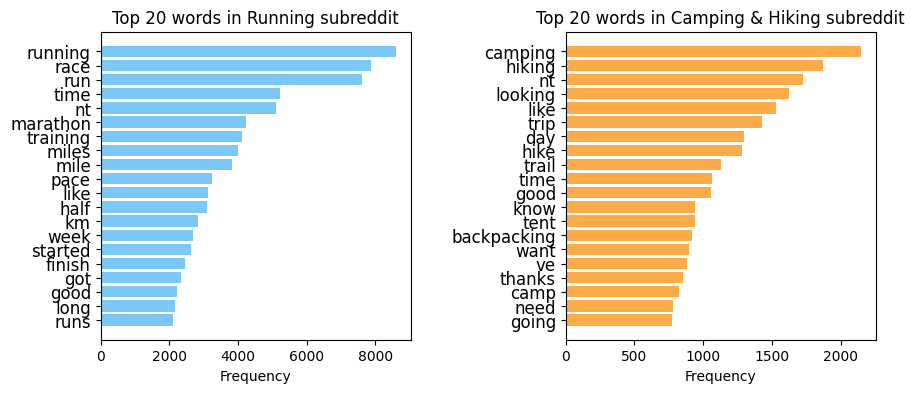

In [36]:
visualise_top_n_grams(run_top20_unigram, hike_top20_unigram, 0.5)